In [2]:
import sys
sys.path.append('..')
from data_utils import *

import torch
import numpy as np
import pickle
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
import importlib
import wandb
import torch.optim as optim
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import matplotlib.gridspec as gridspec

import matplotlib.pyplot as plt

device = torch.device('cuda:0')

### Load Data & Split

In [85]:
# --- Set seed for reproducibility ---
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Loading in data
load_wfs = np.load('2photon_study.npy', allow_pickle=True) # array of shape (2519, 5, 250, 250)
dataset = WaveformDataset(load_wfs.item())

g = torch.Generator()
g.manual_seed(seed)

# Splitting data
val_ratio = 0.0
test_ratio = 0.0
total_size = len(dataset)
val_size = int(total_size * val_ratio)
test_size = int(total_size * test_ratio)
train_size = total_size - val_size - test_size
print(f"split sizes: {train_size, val_size, test_size}")
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g)

batch_size = 25

def custom_collate_fn(batch):
    """
    Custom collate function for WaveformDataset.
    Each item in batch is a tuple: (waveform, arrival_time).
    Returns:
        waveforms: Tensor of shape (batch_size, waveform_length)
        arrival_times: Tensor of shape (batch_size,) or (batch_size, 1)
        hit_times: Tensor of shape (?) with a list of hit times per sample
    """
    waveforms, arrival_times, hit_times = zip(*batch)
    waveforms = torch.stack(waveforms, dim=0)
    waveforms = waveforms.unsqueeze(1)  # adding channel dimension

    # for binary classification
    arrival_times = torch.stack(arrival_times, dim=0)
    arrival_times = arrival_times.unsqueeze(1) # adding channel dimension

    # for regression, just use hit times
    hit_times = [item[2] for item in batch]
    hit_times = torch.tensor(hit_times)
    
    return waveforms, arrival_times, hit_times
    
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers=0,
    pin_memory=False,
    drop_last=False
)

split sizes: (100000, 0, 0)


tensor([400.3000, 400.3000])
torch.Size([25, 1, 800])
torch.Size([25, 1, 800])


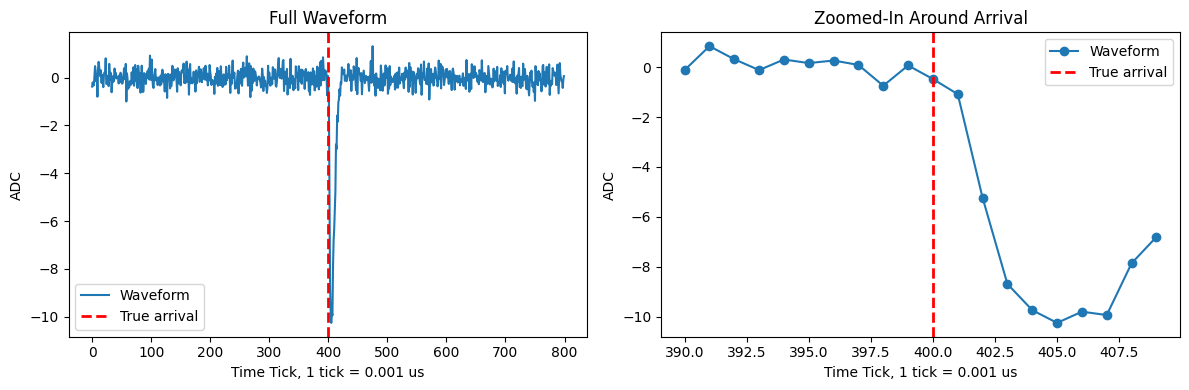

In [92]:
# Inspecting data
waveforms, arrival_times, hit_times = next(iter(train_loader))
print(hit_times[0])
print(waveforms.shape)
print(arrival_times.shape) # mask of input
ticks = np.arange(waveforms[0].shape[1])

# Create two horizontal subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Select the first waveform and arrival
for i, wf in enumerate(waveforms):
    ticks = torch.arange(wf.shape[-1])  # assume ticks = [0, 1, ..., length-1]
    wf = wf.squeeze(0)  # shape: [length]
    arrival_idx = torch.nonzero(arrival_times[i].squeeze(0), as_tuple=False).squeeze().item()

    # First subplot: full waveform
    axs[0].plot(ticks, wf, alpha=1, label='Waveform')
    axs[0].axvline(x=arrival_idx, color='r', linestyle='--', linewidth=2, label='True arrival')
    axs[0].set_title("Full Waveform")
    axs[0].set_xlabel(f"Time Tick, 1 tick = 0.001 us")
    axs[0].set_ylabel("ADC")
    axs[0].legend()

    # Second subplot: zoomed in around true arrival
    zoom_window = 10  # ±10 ticks = 20 total
    start = max(arrival_idx - zoom_window, 0)
    end = min(arrival_idx + zoom_window, wf.shape[0])

    axs[1].plot(ticks[start:end], wf[start:end], alpha=1, label='Waveform', marker = 'o')
    axs[1].axvline(x=arrival_idx, color='r', linestyle='--', linewidth=2, label='True arrival')
    axs[1].set_title("Zoomed-In Around Arrival")
    axs[1].set_xlabel(f"Time Tick, 1 tick = 0.001 us")
    axs[1].set_ylabel("ADC")
    axs[1].legend()

    break  # only do the first waveform

plt.tight_layout()
plt.show()

### Accuracy By Sub-Bin Timing

In [49]:
offset = 0

# --- Load model ---
from model import *
model = UNet1D()
checkpoint = torch.load("0814_50epochs.pth", weights_only=True)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')  # move model to GPU if needed
model.eval()

results = np.zeros(10)
totals = np.zeros(10)

deltas = []

val_progress = tqdm(train_loader, leave=False, position=0)

with torch.no_grad():
    for val_data, val_target, val_hit_times in val_progress:
        val_data = val_data.to(device)  # shape: [B, 1, 1000]
        val_output = model(val_data, mode='bce')  # shape: [B, 1, 1000]
        val_pred = torch.sigmoid(val_output).squeeze(1)  # shape: [B, 1000]

        for b in range(val_pred.shape[0]): # loop over every row
            true_hits = val_hit_times[b] # tensor
            if len(true_hits) == 0:
                continue  # Skip if no true hits

            # Remove duplicate hit times for multi-photon signals
            true_hits = true_hits[:1]
            # Populate total counts of last digits (100 picoseconds)
            for hit in true_hits:
                last_digit = int((hit * 10) % 10)
                totals[last_digit] += 1

            # Predict top k indicies from the model output - correspond to positive time bins - using ground truth info about # hits in the window
            # k = len(true_hits)
            topk_pred_indices = torch.topk(val_pred[b], k=1).indices.cpu().numpy()

            binned_hits = torch.clamp(true_hits + offset, 0, val_data.shape[-1] - 1).to(torch.int)
            
            for p in topk_pred_indices:
                matching_indices = [i for i, t in enumerate(binned_hits) if t == p]
                # print(matching_indices)  
                deltas.append(p - binned_hits[0])
                # print(p, binned_hits[0])
                for idx in matching_indices:
                    last_digit = int(true_hits[idx] * 10 % 10)
                    # print(last_digit)
                    results[last_digit] += 1
                
# Compute accuracies safely
accuracies = np.divide(results, totals, out=np.zeros_like(results), where=totals > 0)

# Print results
print("Accuracy by last digit of predicted arrival time (0–9):")
for i in range(10):
    print(f"Last digit {i}: {accuracies[i]:.3f} ({int(results[i])}/{int(totals[i])})")

Accuracy by last digit of predicted arrival time (0–9):
Last digit 0: 0.517 (5171/10000)
Last digit 1: 1.000 (10000/10000)
Last digit 2: 1.000 (10000/10000)
Last digit 3: 1.000 (10000/10000)
Last digit 4: 1.000 (10000/10000)
Last digit 5: 1.000 (10000/10000)
Last digit 6: 1.000 (10000/10000)
Last digit 7: 1.000 (10000/10000)
Last digit 8: 1.000 (10000/10000)
Last digit 9: 1.000 (10000/10000)


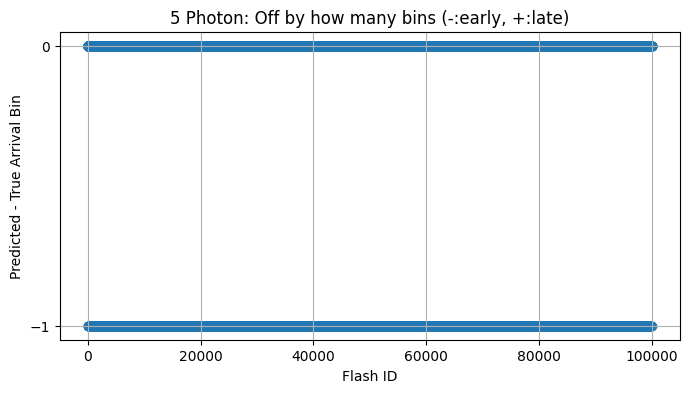

In [55]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(8, 4))
plt.scatter(np.arange(len(deltas)), np.array(deltas))
plt.grid()
plt.xlabel("Flash ID")
plt.ylabel("Predicted - True Arrival Bin")
plt.title("5 Photon: Off by how many bins (-:early, +:late)")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

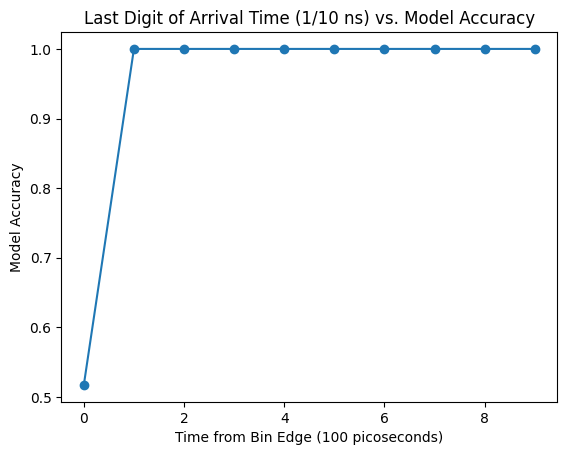

In [51]:
plt.title("Last Digit of Arrival Time (1/10 ns) vs. Model Accuracy")
plt.xlabel("Time from Bin Edge (100 picoseconds)")
plt.ylabel("Model Accuracy")
# plt.plot(np.roll(accuracies, 1), marker='o') # 9 is first digit in the bin (left edge)
plt.plot(accuracies, marker='o') # 9 is 

In [52]:
# ROLL EVERYTHING BY 2: BIN SPANS FROM .9 TO .8
digits = np.arange(10)
# digits = np.roll(digits, 1)
# accuracies = np.roll(accuracies, 1)
# results = np.roll(results, 1)
# totals = np.roll(totals, 1)

[0 1 2 3 4 5 6 7 8 9]


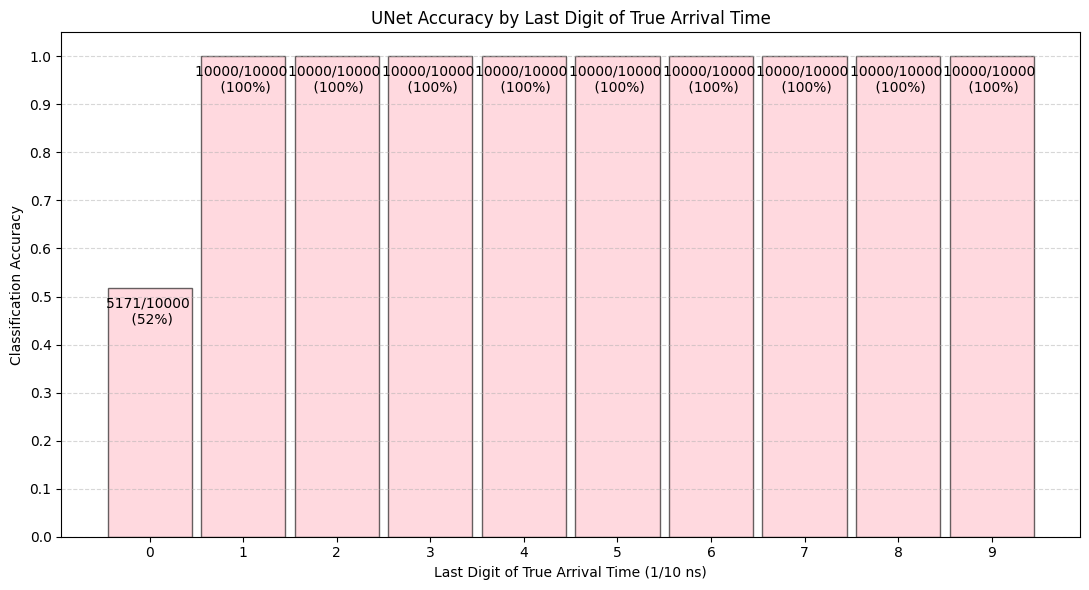

In [53]:
# digits = np.arange(10)
# digits = np.roll(digits, 1)
print(digits)

plt.figure(figsize=(11, 6))
bars = plt.bar(np.arange(10), accuracies, tick_label=digits, color='pink', alpha=0.6, width=0.9, edgecolor='black')

plt.xlabel("Last Digit of True Arrival Time (1/10 ns)")
plt.xticks(np.arange(10), labels=digits)
plt.ylabel("Classification Accuracy")
plt.ylim(0, 1.05)
plt.yticks(np.linspace(0, 1.0, 11))  # 11 ticks at 0.0, 0.1, ..., 1.0
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title("UNet Accuracy by Last Digit of True Arrival Time")

# Add text labels above each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    correct = int(results[i])
    count = int(totals[i])
    plt.text(bar.get_x() + bar.get_width() / 2, height - 0.08,
             f"{correct}/{count} \n ({accuracies[i]*100:.0f}%)", ha='center', va='bottom', fontsize=10, color='black')

# for i in range(len(bin_centers)):
#     if totals[i] > 0:
#         plt.text(bin_centers[i], accuracies[i] - 0.05, f"{int(corrects[i])}/{int(totals[i])} ({accuracies[i]*100:.1f}%)",
#                  ha='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()

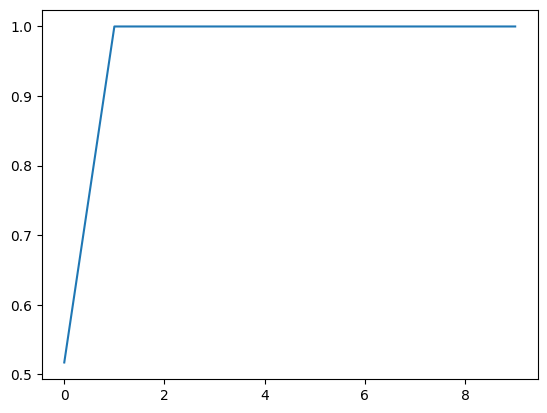

In [54]:
acc_5photon = accuracies
plt.plot(acc_5photon)

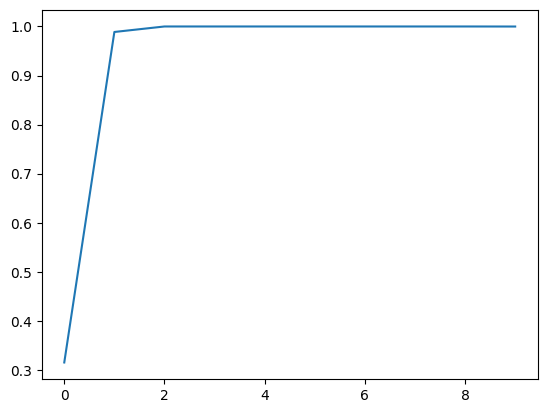

In [45]:
# acc_3photon = accuracies
plt.plot(acc_3photon)

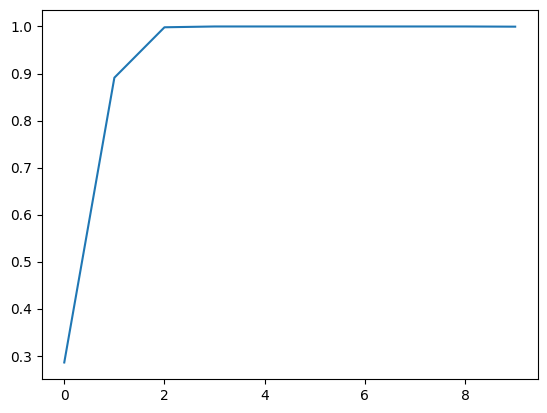

In [31]:
# acc_2photon = accuracies
plt.plot(acc_2photon)

In [12]:
# acc_1photon = accuracies

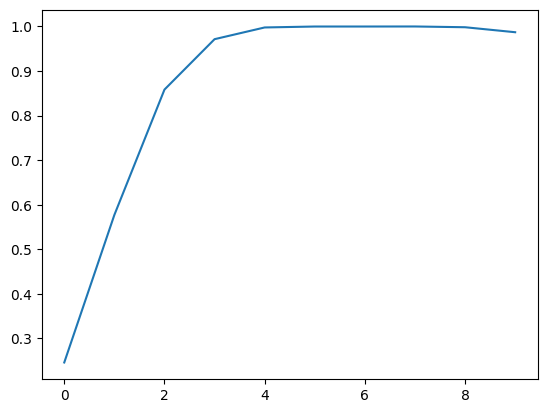

In [13]:
plt.plot(acc_1photon)

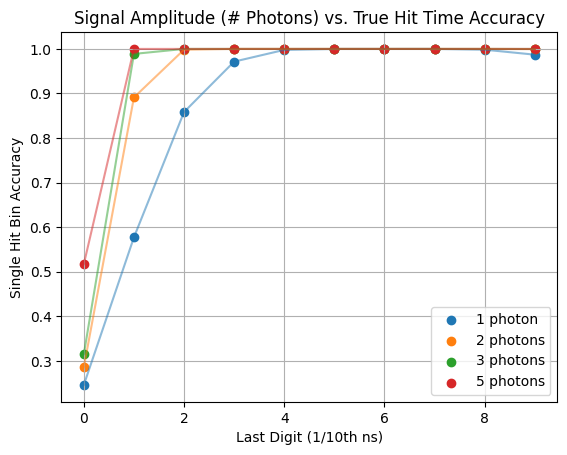

In [61]:
plt.scatter(digits, acc_1photon, label='1 photon')
plt.plot(digits, acc_1photon, alpha=0.5)  # connects the scatter dots

plt.scatter(digits, acc_2photon, label='2 photons')
plt.plot(digits, acc_2photon, alpha=0.5)

plt.scatter(digits, acc_3photon, label='3 photons')
plt.plot(digits, acc_3photon, alpha=0.5)

plt.scatter(digits, acc_5photon, label='5 photons')
plt.plot(digits, acc_5photon, alpha=0.5)

plt.xlabel("Last Digit (1/10th ns)")
plt.ylabel("Single Hit Bin Accuracy")
plt.title("Signal Amplitude (# Photons) vs. True Hit Time Accuracy")
plt.legend()
plt.grid(True)
plt.show()
